# Sionna Coverage Map Tutorial

In this notebook, we demonstrate how to:

1. **Load** an existing 3D scene using Sionna.
2. **Configure** antenna arrays for transmitters and receivers.
3. **Generate** a coverage map (path gain map).
4. **Visualize** the results using Sionna pre-built functions
5. **Plot/Save** the raw coverage map.

Make sure you have Sionna and its dependencies installed. For reference:
```console
pip install sionna
```


In [1]:

from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray
import numpy as np
import matplotlib.pyplot as plt

2025-02-13 16:08:44.670090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 16:08:44.671598: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 16:08:44.697437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 16:08:44.697457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 16:08:44.698253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Load and Preview the Scene

Here, we assume you have a 3D scene XML file generated with our tools `scenegen`. 

In [2]:
# Replace '../Boston/scene.xml' with the path to your scene file.

scene = load_scene("../Boston/scene.xml")
# Preview the loaded scene (a quick 3D visualization).
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## Configure Antenna Arrays

Next, we specify:
1. The **transmit** antenna array: In this example, a planar array with a single element (isotropic pattern).
2. The **receive** antenna array: Also a planar array with a single element (dipole pattern here).

Then, we create a `Transmitter` object with a specific position and orientation, and add it to the `scene`.

Sionna defines the **antenna azimuth** in the range [-π, π) [rad]. The following code converts the commonly used **north-origin, clockwise-degree azimuth** to the Sionna format. Check the code below for details.

In [3]:
# Transmit array (single iso element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="cross"
)

# Create a single transmitter.
#   - Positioned at x=0, y=0, z=100. In the unit of meters.
#   - Orientation set so that it might tilt or rotate accordingly.
tx = Transmitter(
    name="tx",
    position=[0, 0, 100],
    orientation=[-1 * (210 - 90) / 180 * np.pi, 0, 0]
)

# Add the transmitter instance to our scene.
scene.add(tx)

# Set the operating frequency in Hz (3.65 GHz here).
scene.frequency = 3.65e9

# Use a synthetic array for faster simulation.
# If False, Sionna does ray tracing per antenna element (slower for large arrays).
scene.synthetic_array = True

## Generate the Coverage Map

The `coverage_map` method creates a **grid** of receiver locations and performs ray tracing to calculate path gain (or other relevant metrics) at each grid point. Below, we set:

- `max_depth=5` (maximum number of reflections/refractions/diffractions)
- `diffraction=True` to include diffraction effects.
- `cm_cell_size=(2., 2.)` for a 2×2 meter grid resolution.
- `cm_size=[512, 512]` specifying the coverage map spans 512×512 meters.
- `num_samples=int(2e6)` controlling how many rays are sampled (reduce if running out of memory).

Run this step carefully—depending on your hardware, it can take a while to compute. **Progress** (if any) will be shown in the console.

In [4]:
cm = scene.coverage_map(
    max_depth=5,
    diffraction=True,          # Account for diffraction effects
    cm_cell_size=(2., 2.),    # Coverage map grid size in meters
    combining_vec=None,
    cm_center=[0, 0, 1.5],     # Center of the coverage map plane
    cm_orientation=[0, 0, 0],  # Orientation of the coverage map plane
    cm_size=[512, 512],       # Size of the coverage map in meters. The number of cells in the x and y directions should be [cm_size / cm_cell_size]
    precoding_vec=None,
    num_samples=int(2e6)       # Ray-sample budget (lower if memory is limited)
)

## Preview the Coverage Map
Sionna can overlay the coverage map on the scene preview. This allows you to visually verify how the path gain results align with the 3D environment.

In [5]:
scene.preview(coverage_map=cm)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## Display Coverage Map in 2D
`cm.show(tx=0)` gives a built-in quick plot for the coverage map of transmitter 0.

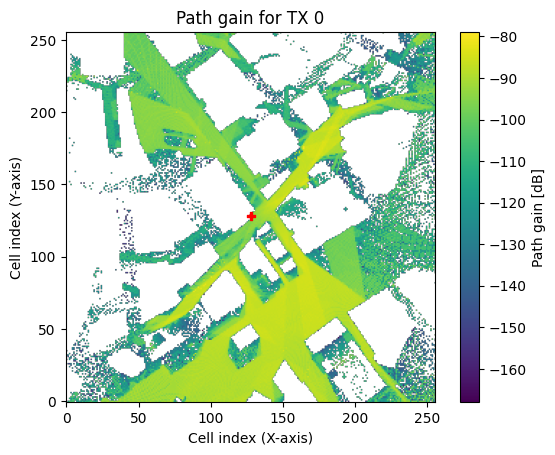

In [6]:
cm.show(tx=0);

## Plotting/Saving the raw Coverage Map

Here, we extract the raw **coverage map** data from the Sionna:
- Convert it to a NumPy array.
- Show both the raw linear data, dB scale, and a **flipped** version.

Notice that Sionna's indexing differs from your typical coordinate origin assumptions, so flipping the map can help align with your expected orientation.

/tmp/ipykernel_779547/85663788.py:5: RuntimeWarning: divide by zero encountered in log10
  cm_npy_db = 10 * np.log10(cm_npy)
/tmp/ipykernel_779547/85663788.py:6: RuntimeWarning: divide by zero encountered in log10
  cm_npy_flipped_db = 10 * np.log10(np.flip(cm_npy, 0))


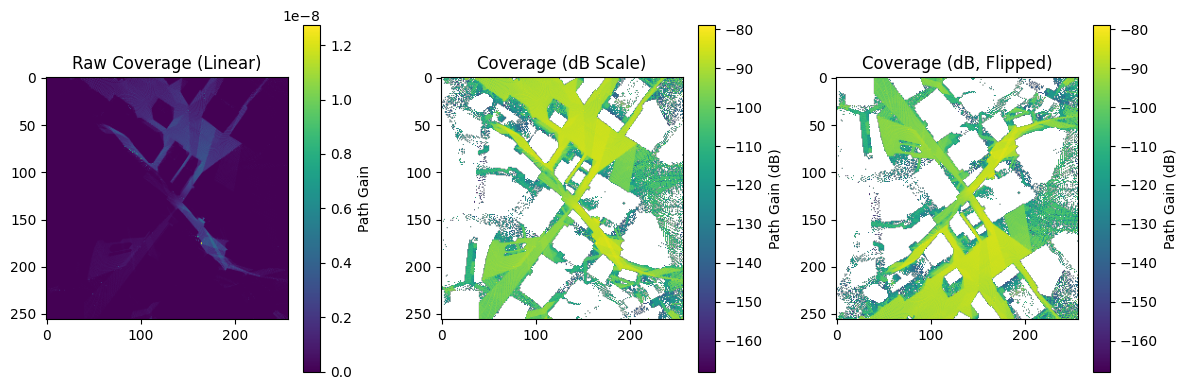

In [7]:
# Extract path gain from the coverage map. shape: (1, height, width)
cm_npy = cm.path_gain.numpy()[0, :, :]

# Convert path gain to dB scale. Also demonstrate flipping along axis 0.
cm_npy_db = 10 * np.log10(cm_npy)
cm_npy_flipped_db = 10 * np.log10(np.flip(cm_npy, 0))

# Create side-by-side plots for raw, dB, and flipped dB.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Raw coverage map (linear scale)
im_raw = axes[0].imshow(cm_npy)
axes[0].set_title('Raw Coverage (Linear)')
cbar_raw = plt.colorbar(im_raw, ax=axes[0])
cbar_raw.set_label('Path Gain')

# 2) Coverage map in dB scale
im_db = axes[1].imshow(cm_npy_db)
axes[1].set_title('Coverage (dB Scale)')
cbar_db = plt.colorbar(im_db, ax=axes[1])
cbar_db.set_label('Path Gain (dB)')

# 3) Flipped coverage map in dB scale
im_db_flip = axes[2].imshow(cm_npy_flipped_db)
axes[2].set_title('Coverage (dB, Flipped)')
cbar_db_flip = plt.colorbar(im_db_flip, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB)')

plt.tight_layout()
plt.show()